## Importing required libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from collections import Counter
import re

## Defining Utility Functions

In [2]:
# Utility functions
def preprocess_text(text):
    """
    Clean and preprocess text data: remove special characters, convert to lowercase.
    """
    if pd.isnull(text):
        return ""
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text

def build_vocab(texts, vocab_size=5000):
    """
    Build a vocabulary with a fixed size from the dataset.
    """
    counter = Counter()
    for text in texts:
        counter.update(text.split())
    most_common = counter.most_common(vocab_size - 1)
    vocab = {word: idx + 1 for idx, (word, _) in enumerate(most_common)}
    vocab["<UNK>"] = 0
    return vocab

def encode_texts(texts, vocab, max_len=50):
    """
    Encode texts into numerical representations using the vocabulary.
    """
    encoded = [[vocab.get(word, 0) for word in text.split()] for text in texts]
    return np.array([x[:max_len] + [0] * (max_len - len(x)) if len(x) < max_len else x[:max_len] for x in encoded])

## Loading and Preprocessing the Dataset

In [3]:
# Load the dataset
dataset_path = './dataset/Tweets.csv'
df = pd.read_csv(dataset_path)

# Extract relevant columns
df = df[['text', 'airline_sentiment']]
df = df.dropna(subset=['text', 'airline_sentiment'])

# Preprocess text
df["text"] = df["text"].apply(preprocess_text)

# Encode labels
label_encoder = LabelEncoder()
df["airline_sentiment"] = label_encoder.fit_transform(df["airline_sentiment"])

## Feature Extraction Using TF-IDF and Word Embedding

In [4]:
# TF-IDF Feature Extraction
tfidf_vectorizer = TfidfVectorizer(max_features=500)
X_tfidf = tfidf_vectorizer.fit_transform(df["text"]).toarray()

# Word Embedding Preparation
vocab = build_vocab(df["text"])
X_embedded = encode_texts(df["text"], vocab)

# Combining TF-IDF and Embeddings for Model Input
X_combined = np.hstack((X_embedded, X_tfidf))

## 70:30 Train Test Split

In [5]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, df["airline_sentiment"], test_size=0.3, random_state=42)

## Defining Neural Network Classes

In [6]:
# class SimpleNN:
#     def __init__(self, input_size, hidden_size, output_size):
#         self.weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
#         self.weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
#         self.bias_hidden = np.zeros((1, hidden_size))
#         self.bias_output = np.zeros((1, output_size))
    
#     def softmax(self, x):
#         exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
#         return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
#     def forward(self, X):
#         self.hidden = np.maximum(0, np.dot(X, self.weights_input_hidden) + self.bias_hidden)
#         self.output = self.softmax(np.dot(self.hidden, self.weights_hidden_output) + self.bias_output)
#         return self.output
    
#     def backward(self, X, y, lr=0.01):
#         m = X.shape[0]
#         y_one_hot = np.zeros((m, self.bias_output.shape[1]))
#         y_one_hot[np.arange(m), y] = 1

#         output_error = self.output - y_one_hot
#         hidden_error = np.dot(output_error, self.weights_hidden_output.T) * (self.hidden > 0)

#         self.weights_hidden_output -= lr * np.dot(self.hidden.T, output_error) / m
#         self.bias_output -= lr * np.sum(output_error, axis=0, keepdims=True) / m
#         self.weights_input_hidden -= lr * np.dot(X.T, hidden_error) / m
#         self.bias_hidden -= lr * np.sum(hidden_error, axis=0, keepdims=True) / m
    
#     def train(self, X, y, epochs=100, lr=0.01):
#         for epoch in range(epochs):
#             predictions = self.forward(X)
#             loss = -np.mean(np.log(predictions[np.arange(len(y)), y]))
#             self.backward(X, y, lr)
#             if (epoch + 1) % 10 == 0:
#                 print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")
    
#     def predict(self, X):
#         predictions = self.forward(X)
#         return np.argmax(predictions, axis=1)

In [7]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"Class Weights: {class_weights_dict}")

class SimpleNNWithClassWeights:
    def __init__(self, input_size, hidden_size, output_size, class_weights):
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
        self.bias_hidden = np.zeros((1, hidden_size))
        self.bias_output = np.zeros((1, output_size))
        self.class_weights = class_weights  # Incorporate class weights
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        self.hidden = np.maximum(0, np.dot(X, self.weights_input_hidden) + self.bias_hidden)
        self.output = self.softmax(np.dot(self.hidden, self.weights_hidden_output) + self.bias_output)
        return self.output
    
    def backward(self, X, y, lr=0.01):
        m = X.shape[0]
        y_one_hot = np.zeros((m, self.bias_output.shape[1]))
        y_one_hot[np.arange(m), y] = 1

        # Adjust output error with class weights
        output_error = (self.output - y_one_hot) * np.array([self.class_weights[y[i]] for i in range(m)]).reshape(-1, 1)
        hidden_error = np.dot(output_error, self.weights_hidden_output.T) * (self.hidden > 0)

        self.weights_hidden_output -= lr * np.dot(self.hidden.T, output_error) / m
        self.bias_output -= lr * np.sum(output_error, axis=0, keepdims=True) / m
        self.weights_input_hidden -= lr * np.dot(X.T, hidden_error) / m
        self.bias_hidden -= lr * np.sum(hidden_error, axis=0, keepdims=True) / m
    
    def train(self, X, y, epochs=100, lr=0.01):
        for epoch in range(epochs):
            predictions = self.forward(X)
            loss = -np.mean(np.log(predictions[np.arange(len(y)), y]) * np.array([self.class_weights[y[i]] for i in range(len(y))]))
            self.backward(X, y, lr)
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")
    
    def predict(self, X):
        predictions = self.forward(X)
        return np.argmax(predictions, axis=1)

Class Weights: {0: 0.5367693274670019, 1: 1.5422121896162528, 2: 2.0467345715997602}


## Training the Model

In [9]:
# Initialize and train the model
input_size = X_train.shape[1]
hidden_size = 64
output_size = len(label_encoder.classes_)

# nn_model = SimpleNN(input_size, hidden_size, output_size)
nn_model = SimpleNNWithClassWeights(input_size, hidden_size, output_size, class_weights)
nn_model.train(X_train, y_train.values, epochs=100, lr=0.01)

Epoch 10, Loss: 1.0822
Epoch 20, Loss: 1.0674
Epoch 30, Loss: 1.0565
Epoch 40, Loss: 1.0557
Epoch 50, Loss: 1.0606
Epoch 60, Loss: 1.0566
Epoch 70, Loss: 1.0530
Epoch 80, Loss: 1.0451
Epoch 90, Loss: 1.0376
Epoch 100, Loss: 1.0373


## Evaluating model performance

In [10]:
# Evaluate the model
y_pred = nn_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5879


## Further evaluation of model performance

Epoch 10, Loss: 1.0731
Epoch 20, Loss: 1.0522
Epoch 30, Loss: 1.0496
Epoch 40, Loss: 1.0243
Epoch 50, Loss: 1.0260
Epoch 60, Loss: 1.0220
Epoch 70, Loss: 1.0149
Epoch 80, Loss: 1.0094
Epoch 90, Loss: 0.9988
Epoch 100, Loss: 0.9934


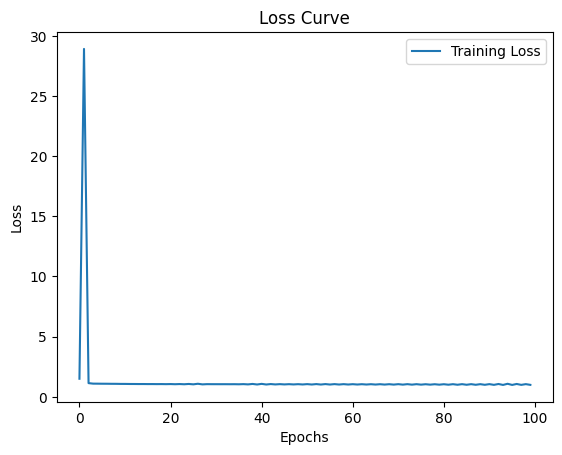

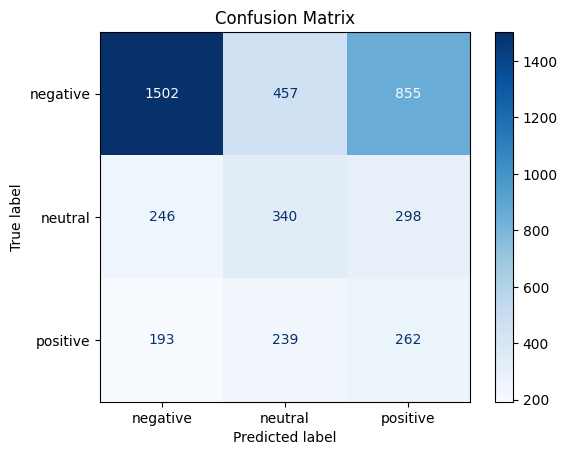

Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.53      0.63      2814
     neutral       0.33      0.38      0.35       884
    positive       0.19      0.38      0.25       694

    accuracy                           0.48      4392
   macro avg       0.43      0.43      0.41      4392
weighted avg       0.59      0.48      0.52      4392



In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Plot the training loss
class LossTracker:
    """
    Helper class to track and visualize loss during training.
    """
    def __init__(self):
        self.losses = []

    def add_loss(self, loss):
        self.losses.append(loss)

    def plot_losses(self):
        plt.plot(self.losses, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()
        plt.show()

# Update the training process to track loss
# class SimpleNNWithLossTracking(SimpleNN):
class SimpleNNWithLossTracking(SimpleNNWithClassWeights):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker = LossTracker()
    
    def train(self, X, y, epochs=100, lr=0.01):
        for epoch in range(epochs):
            predictions = self.forward(X)
            loss = -np.mean(np.log(predictions[np.arange(len(y)), y]))
            self.loss_tracker.add_loss(loss)
            self.backward(X, y, lr)
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

# Retrain the model with loss tracking
# nn_model = SimpleNNWithLossTracking(input_size, hidden_size, output_size)
nn_model = SimpleNNWithLossTracking(input_size, hidden_size, output_size, class_weights)
nn_model.train(X_train, y_train.values, epochs=100, lr=0.01)

# Plot the loss curve
nn_model.loss_tracker.plot_losses()

# Confusion matrix
y_pred = nn_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))